# Model-free vs. model-based control: THE two step task

The **two step task** is one of the most iconic tasks in RL (see Daw, Gershman, Seymour, Dayan, & Dolan, Neuron 2011 for details). There are a lot of facets to it. For now, we will only focus on the behaviour of the model-free learner.

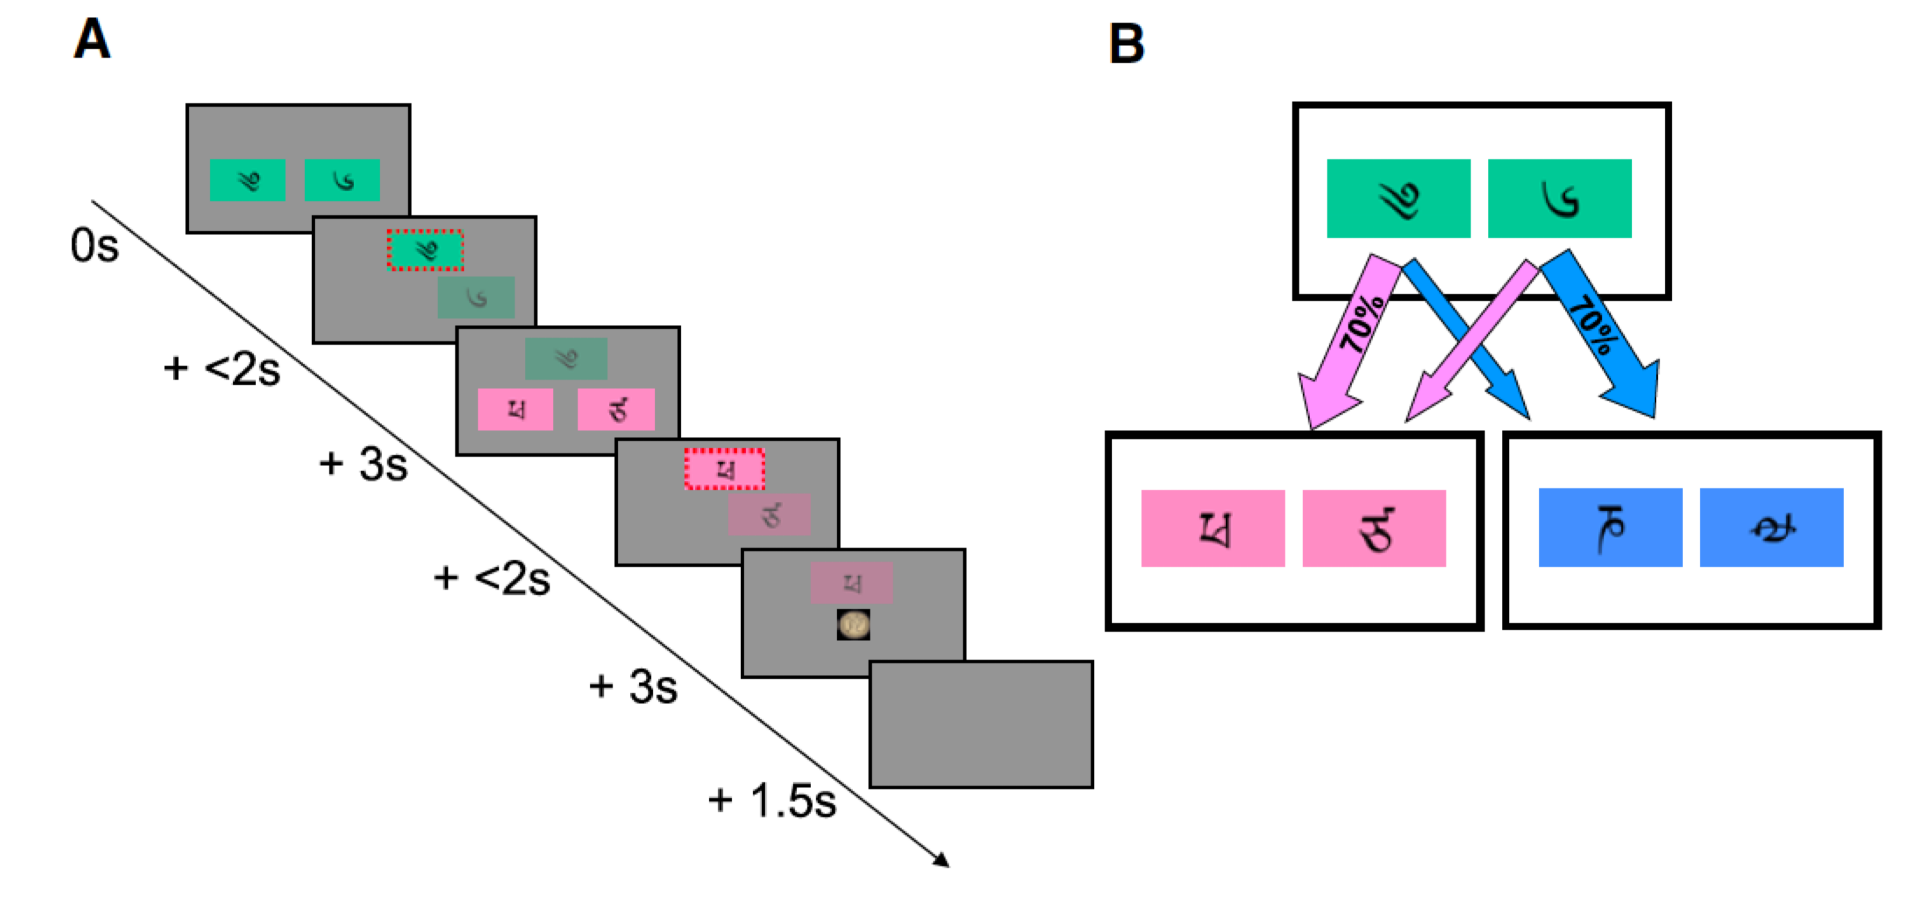

This code is based on the excellent paper from Thomas Akam, Rui Costa and Peter Dayan (PLOS Computational Biology, 2015): https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004648#sec002. This is a great ressource for learning many more things about the two-step task and possible ways to model it.

The key point of the paper is that different agents can show different learning patterns. Of particular interest is the analysis of '**stay probabilities**' for the first level choice as a function of whether the previous trial was **rewarding** and the **transition** to the second level in the previous trial was **common** or **rare**.

While a **model-free learner** simply repeats rewarded actions irrespective of the transition type (common, rare) (left), a **model-based learner** will repeat those actions that will likely lead to a reward (middle). This means a model-based agent will try to choose the first-level option that has a *common transition* to the high reward option.

It turns out that actual observed actions appear to be a mixture of both strategies (right).

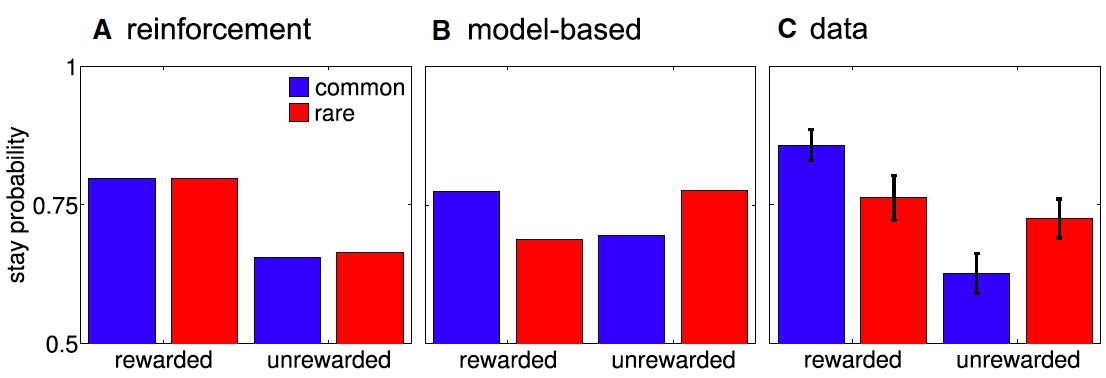

We start with the usual imports and defining some helper functions.

In [ ]:
# Imports
import numpy as np                 
import matplotlib.pyplot as plt
from random import random, randint
import sys

log_max_float = np.log(sys.float_info.max/2.1) # Log of largest possible floating point number.

In [ ]:
# @title Helper functions

def choose(P):
  
  "Takes vector of probabilities P summing to 1, returns integer s with prob P[s]"

  return sum(np.cumsum(P) < random())

def softmax(Q,T):
  
  "Softmax choice probs given values Q and inverse temp T."

  QT = Q * T
  QT[QT > log_max_float] = log_max_float # Protection against overflow in exponential.    
  expQT = np.exp(QT)

  return expQT/expQT.sum()

def gauss_rand_walks(n_trials, step_SD, p_range = [0, 1], n_walks = 2):
  
  'Generate a set of reflecting Gaussian random walks.'
  
  walks = np.random.normal(scale = step_SD, size = (n_trials, n_walks))
  walks[0,:] = np.random.rand(n_walks)
  walks = np.cumsum(walks, 0)
  walks = np.mod(walks, 2.)
  walks[walks > 1.] = 2. - walks[walks > 1.]
  
  if p_range != [0, 1]:
      walks = walks  * (p_range[1]- p_range[0]) + p_range[0]
  
  return walks

def fixed_length_blocks(n_trials, probs, block_length):
  
  'Reversals in reward probabilities every block_length_trials.'
  
  block_1 = np.tile(probs,(block_length,1))
  block_2 = np.tile(probs[::-1],(block_length,1))
  
  return np.tile(np.vstack([block_1,block_2]), \
          (np.ceil(n_trials / (2. * block_length)),1,))[:n_trials,:]

def task_stats(n_trials = 1000,rew_gen = 'walks',step_SD = 0.025):
  
  'Generate a fresh set of reward probabilities.'

  if rew_gen == 'walks':   
      reward_probs  = gauss_rand_walks(n_trials, step_SD, p_range = [0.25, 0.75],
                                              n_walks = 4).reshape(n_trials,2,2)
  elif rew_gen == 'blocks':
      reward_probs = np.tile(fixed_length_blocks(n_trials, [0.2,0.8], 50 
                                  ).reshape(n_trials,2,1),[1,1,2])  
  rew_prob_iter = iter(reward_probs)

  return reward_probs, rew_prob_iter

def first_step(choice,com_prob = 0.7):
  'Given first step choice generate second step.'
  transition  = int(random() <  com_prob)   # 1 if common, 0 if rare.
  second_step = int(choice == transition)        # Choice 1 (0) commonly leads to second_step 1 (0).
  return second_step, transition

def second_step(second_step, choice_2,rew_prob_iter):
  outcome = int(random() < next(rew_prob_iter)[second_step, choice_2])
  return outcome

from scipy.stats import sem, ttest_rel

def setup_figure(fig_no = 1, clf = True):
  plt.figure(fig_no)
  if clf:plt.clf()

def stay_prob_plot(stay_probs, fig_no = 1, clf = True):
  'Plot stay probabilities with SEM errorbars for a list of sessions.'
  setup_figure(fig_no, clf)
  plt.bar(np.arange(1,5), np.mean(stay_probs,0), yerr = sem(stay_probs,0),
          error_kw = {'ecolor': 'r', 'capsize': 5, 'elinewidth': 5})
  plt.ylim(0,1)
  plt.xlim(0,5)
  plt.xticks([1,2,3,4],['Reward \n Common', 'Reward \n Rare', 'No Reward \n Common', 'No Reward \n Rare'])
  plt.ylabel('Stay Probability')

# Part 1: Define a model-free Q-Learner in the two-step task

In [ ]:
def simulate(n_trials = 1000):

  alpha, iTemp, gamma = 0.5 , 5, 0.9 

  # initialise variables:
  transition = np.zeros(n_trials)

  Q_td_1 = np.zeros(2)     # First step action values.
  Q_td_2 = np.zeros([2,2]) # Second step action values, indicies: [state, action]

  choices, second_steps, choices_s, outcomes = (np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int))

  # initialise task statistics:
  reward_probs, rew_prob_iter = task_stats(n_trials)

  for i in range(n_trials):
    # Generate trial events.
    choice_1      = choose(softmax(Q_td_1, iTemp))      # First step action.

    next_state, t = first_step(choice_1)                  # Second step state.

    choice_2      = choose(softmax(Q_td_2[next_state,:], iTemp)) # Second_step action.

    reward        = second_step(next_state, choice_2, rew_prob_iter)            # Trial outcome.   

    # update action values
    Q_td_1[choice_1] = Q_td_1[choice_1] +  alpha * (reward - Q_td_1[choice_1])

    # Not that first level and second level are treated as independent - 
    # But you could also do:
    # Q_td_1[c]     = Q_td_1[c] +  alpha * (o + gamma*np.max(Q_td_2[s,:]) - Q_td_1[c])

    Q_td_2[next_state,choice_2] = Q_td_2[next_state,choice_2] + alpha * (reward - Q_td_2[next_state,choice_2])

    choices[i], second_steps[i], choices_s[i], outcomes[i], transition[i]  = (choice_1, next_state, choice_2, reward, t)

  return choices, second_steps, choices_s, outcomes, transition

We can now use this function and simulate some data. Below you find plots for simulated first- and second-level choices. 

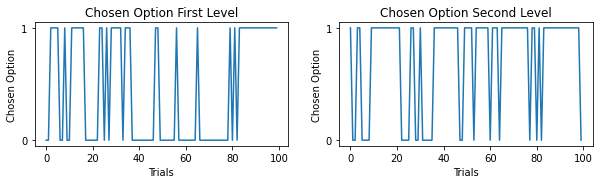

In [ ]:
choices_1, next_states, choices_2, outcomes, transition = simulate(n_trials = 100)

plt.rcParams['figure.figsize'] = [10, 5]
rows = 2
cols = 2
fig = plt.figure() 

fig_count = 1
fig.add_subplot(rows, cols, fig_count)
plt.plot(choices_1)
plt.xlabel('Trials')
plt.ylabel('Chosen Option')
plt.yticks([0,1])
plt.title('Chosen Option First Level')

fig_count = 2
fig.add_subplot(rows, cols, fig_count)
plt.plot(choices_2)
plt.xlabel('Trials')
plt.ylabel('Chosen Option')
plt.yticks([0,1])
plt.title('Chosen Option Second Level')

plt.show()

In [ ]:
# @title Exercise 1.1: How does the above learning work?

Can you understand what's going on in the above algorithm? And what kind of behaviour does it produce and predict?

What parameters do you think performance depends on, and how?

# Part 2: Get 'Stay Probabilities'

We can now analyse the 'stay probabilities' for the first level choice in the model-free Q-learner. First, let's compute those stay probabilities as a function of whether the previous trial had a common or rare transition and was rewarded:

In [ ]:
def session_stay_probs(choices=[],transitions=[],outcomes=[]):
  
  'Evaluate stay probabilities for a single session'

  if len(choices)==0:
    choices, second_steps, choices_s, outcomes, transitions = simulate(n_trials = 100)

  stay = choices[1:] == choices[:-1]

  stay_probs = np.zeros(4)

  # idx_RewComm = transitions[:-1]==1 and  outcomes[:-1]==1
  idx_RewComm = np.logical_and(transitions[:-1]==1, outcomes[:-1]==1)
  idx_RewRare = np.logical_and(transitions[:-1]==0, outcomes[:-1]==1)
  idx_NRewComm = np.logical_and(transitions[:-1]==1, outcomes[:-1]==0)
  idx_NRewRare = np.logical_and(transitions[:-1]==0, outcomes[:-1]==0)

  stay_probs[0] = np.mean(stay[idx_RewComm]) # Rewarded, common transition.
  stay_probs[1] = np.mean(stay[idx_RewRare]) # Rewarded, rare transition.
  stay_probs[2] = np.mean(stay[idx_NRewComm]) # Non-rewarded, common transition.
  stay_probs[3] = np.mean(stay[idx_NRewRare]) # Non-rewarded, rare transition.

  return stay_probs

We can now define a function to plot these stay probabilities:

Session 0 of 10 done.
Session 1 of 10 done.
Session 2 of 10 done.
Session 3 of 10 done.
Session 4 of 10 done.
Session 5 of 10 done.
Session 6 of 10 done.
Session 7 of 10 done.
Session 8 of 10 done.
Session 9 of 10 done.


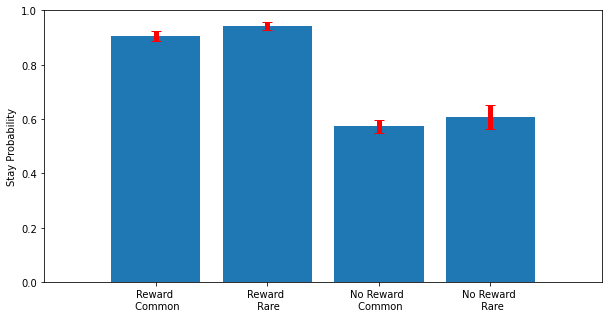

In [ ]:
n_sessions = 10     # Number of sessions per agent.
n_trials   = 100  # Number of trials per session.

stay_probs = np.zeros((n_sessions,4))

for idx_sess in np.arange(n_sessions):
  choices, second_steps, choices_s, outcomes, transitions = simulate(n_trials)
  stay_probs[idx_sess,:] = session_stay_probs(choices,transitions,outcomes)

  print("Session " + str(idx_sess) + " of " + str(n_sessions) + " done.")

stay_prob_plot(stay_probs) # this is a helper function to plot from above

In [ ]:
# @title Exercise 2.1: What do we see?

We've now reproduced the same result for a model-free learner as in the paper. Can you make sense of how we got here?

How will different parameter settings affect those results?

In [ ]:
# @title Exercise 2.2: Thinking ahead

Do you have an idea what we'd need to change to produce the behaviour of the model-based agent?